In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer

from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

## Data Preprocessing

In [2]:
df = pd.read_csv('secondary_data.csv',sep=';', on_bad_lines='skip')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [4]:
# Keep naming consistent
df = df.rename(columns={"Cap-surface": "cap-surface"})

In [5]:
# Because of multicolinearity and name has no correlation
df = df.drop(columns=['spore-print-color',
                     'has-ring'])

#Binary Encoding
binary_mapping = {'[t]': 1, '[f]': 0}
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].map(binary_mapping)
binary_mapping = {'p': 1, 'e': 0}
df['class'] = df['class'].map(binary_mapping)

In [6]:
# Too many Nan values where imputation is not good to do
df = df.drop(columns=['stem-root', 'stem-surface', 'veil-type', 'veil-color'])

In [7]:
df['gill-attachment'].fillna('[?]', inplace=True)
df['ring-type'].fillna('[?]', inplace=True)
df['cap-surface'].fillna('[?]', inplace=True)
df['gill-spacing'].fillna('[?]', inplace=True)
# As per the ? key used, we simply filled in the Nans as they are essentially unknown

In [8]:
columns_to_apply_multilabeling = ['cap-shape','cap-surface','cap-color','gill-attachment', 'gill-spacing', 'gill-color','stem-color','ring-type','season']

for col in columns_to_apply_multilabeling:
    mlb = MultiLabelBinarizer()
    column = df[col].apply(lambda x: x.strip('[]').split(', '))
    
    encoded_data = mlb.fit_transform(column)
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_+"_"+col)
    df = df.drop(col, axis=1)
    df = pd.concat([df, encoded_df], axis=1)

In [9]:
df.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,habitat,b_cap-shape,c_cap-shape,f_cap-shape,o_cap-shape,...,g_ring-type,l_ring-type,m_ring-type,p_ring-type,r_ring-type,z_ring-type,a_season,s_season,u_season,w_season
0,1,15.26,NaN,16.95,17.09,d,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,16.60,NaN,17.99,18.19,d,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,14.07,NaN,17.80,17.74,d,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,14.17,NaN,15.77,15.98,d,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,1,14.64,NaN,16.53,17.20,d,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [10]:
X = df.drop(columns = {'habitat','cap-diameter','stem-height','stem-width'})

##drop all columns with NAN
X = X.dropna(axis=1)

In [11]:
y = df['habitat']

In [12]:
#Feature Selection using Chi-Squared Test and SelectKBest
selector = SelectKBest(score_func=chi2, k=10)  # Specify the desired number of features
X_selected = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)

In [13]:
X_selected_df.head(15)

,b_cap-shape,p_cap-shape,i_cap-surface,w_cap-color,e_gill-attachment,f_gill-color,k_gill-color,e_ring-type,l_ring-type,r_ring-type
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0


In [14]:
#Encoding y
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(y)

In [15]:
X = df
X = X.drop(columns = {'habitat'})

In [16]:
X.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,b_cap-shape,c_cap-shape,f_cap-shape,o_cap-shape,p_cap-shape,...,g_ring-type,l_ring-type,m_ring-type,p_ring-type,r_ring-type,z_ring-type,a_season,s_season,u_season,w_season
0,1,15.26,NaN,16.95,17.09,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,16.60,NaN,17.99,18.19,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,14.07,NaN,17.80,17.74,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,14.17,NaN,15.77,15.98,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,1,14.64,NaN,16.53,17.20,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [17]:
# Check for any NaN values in X
print(X.isnull().any())

class                   False
cap-diameter            False
does-bruise-or-bleed     True
stem-height             False
stem-width              False
                        ...  
z_ring-type             False
a_season                False
s_season                False
u_season                False
w_season                False
Length: 86, dtype: bool


In [18]:
X = X.drop(columns=['does-bruise-or-bleed'])

In [19]:
#Feature importance Using RandomForests
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)
feature_importances = rf_classifier.feature_importances_
feature_importances_with_names = list(zip(X.columns, feature_importances))
for name, importance in feature_importances_with_names:
    print(f"Feature: {name}, Importance: {importance}")

Feature: class, Importance: 0.017708946215513346
Feature: cap-diameter, Importance: 0.15128617410142794
Feature: stem-height, Importance: 0.1375716522986756
Feature: stem-width, Importance: 0.17700086361686804
Feature: b_cap-shape, Importance: 0.011196231665930027
Feature: c_cap-shape, Importance: 0.003777799617826481
Feature: f_cap-shape, Importance: 0.007872199738169841
Feature: o_cap-shape, Importance: 0.00451451891128577
Feature: p_cap-shape, Importance: 0.005855178584482346
Feature: s_cap-shape, Importance: 0.004953786265033606
Feature: x_cap-shape, Importance: 0.010027498804047068
Feature: ?_cap-surface, Importance: 0.015185677989508001
Feature: d_cap-surface, Importance: 0.0068481772189474864
Feature: e_cap-surface, Importance: 0.002270430064524804
Feature: g_cap-surface, Importance: 0.009716795191013582
Feature: h_cap-surface, Importance: 0.004048825995827189
Feature: i_cap-surface, Importance: 0.007956344105317748
Feature: k_cap-surface, Importance: 0.003451298347408334
Featur

In [20]:
#Top 10 important features
for i, (name, importance) in enumerate(feature_importances_with_names[:10], start=1):
    print(f"{i}. Feature: {name}, Importance: {importance}")

1. Feature: class, Importance: 0.017708946215513346
2. Feature: cap-diameter, Importance: 0.15128617410142794
3. Feature: stem-height, Importance: 0.1375716522986756
4. Feature: stem-width, Importance: 0.17700086361686804
5. Feature: b_cap-shape, Importance: 0.011196231665930027
6. Feature: c_cap-shape, Importance: 0.003777799617826481
7. Feature: f_cap-shape, Importance: 0.007872199738169841
8. Feature: o_cap-shape, Importance: 0.00451451891128577
9. Feature: p_cap-shape, Importance: 0.005855178584482346
10. Feature: s_cap-shape, Importance: 0.004953786265033606


## Data Visualizations

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
feats_to_use = ['class', 'cap-diameter', 'stem-height', 'stem-width', 
                'b_cap-shape', 'c_cap-shape', 'f_cap-shape', 'o_cap-shape', 'p_cap-shape']

In [23]:
vis_df = pd.concat([X[feats_to_use], y], axis=1)

In [24]:
vis_df

,class,cap-diameter,stem-height,stem-width,b_cap-shape,c_cap-shape,f_cap-shape,o_cap-shape,p_cap-shape,habitat
0,1,15.26,16.95,17.09,0,0,0,0,0,d
1,1,16.60,17.99,18.19,0,0,0,0,0,d
2,1,14.07,17.80,17.74,0,0,0,0,0,d
3,1,14.17,15.77,15.98,0,0,1,0,0,d
4,1,14.64,16.53,17.20,0,0,0,0,0,d
...,...,...,...,...,...,...,...,...,...,...
61064,1,1.18,3.93,6.22,0,0,0,0,0,d
61065,1,1.27,3.18,5.43,0,0,1,0,0,d
61066,1,1.27,3.86,6.37,0,0,0,0,0,d
61067,1,1.24,3.56,5.44,0,0,1,0,0,d


In [25]:
vals = vis_df['habitat'].value_counts()

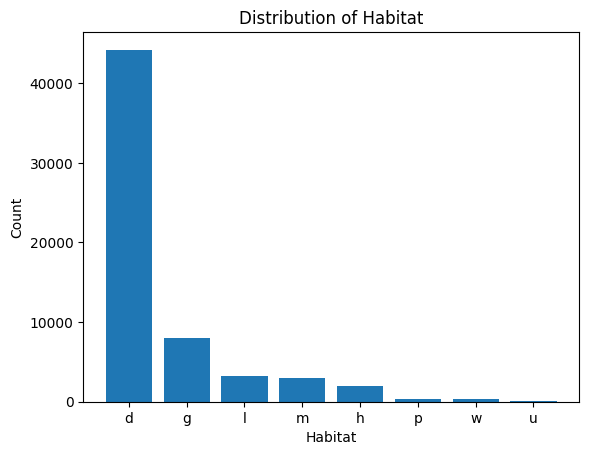

In [26]:
##distribution of the output class coutns
plt.bar(x=vals.index, height=vals)

plt.xlabel('Habitat')
plt.ylabel('Count')
plt.title('Distribution of Habitat')

plt.show()

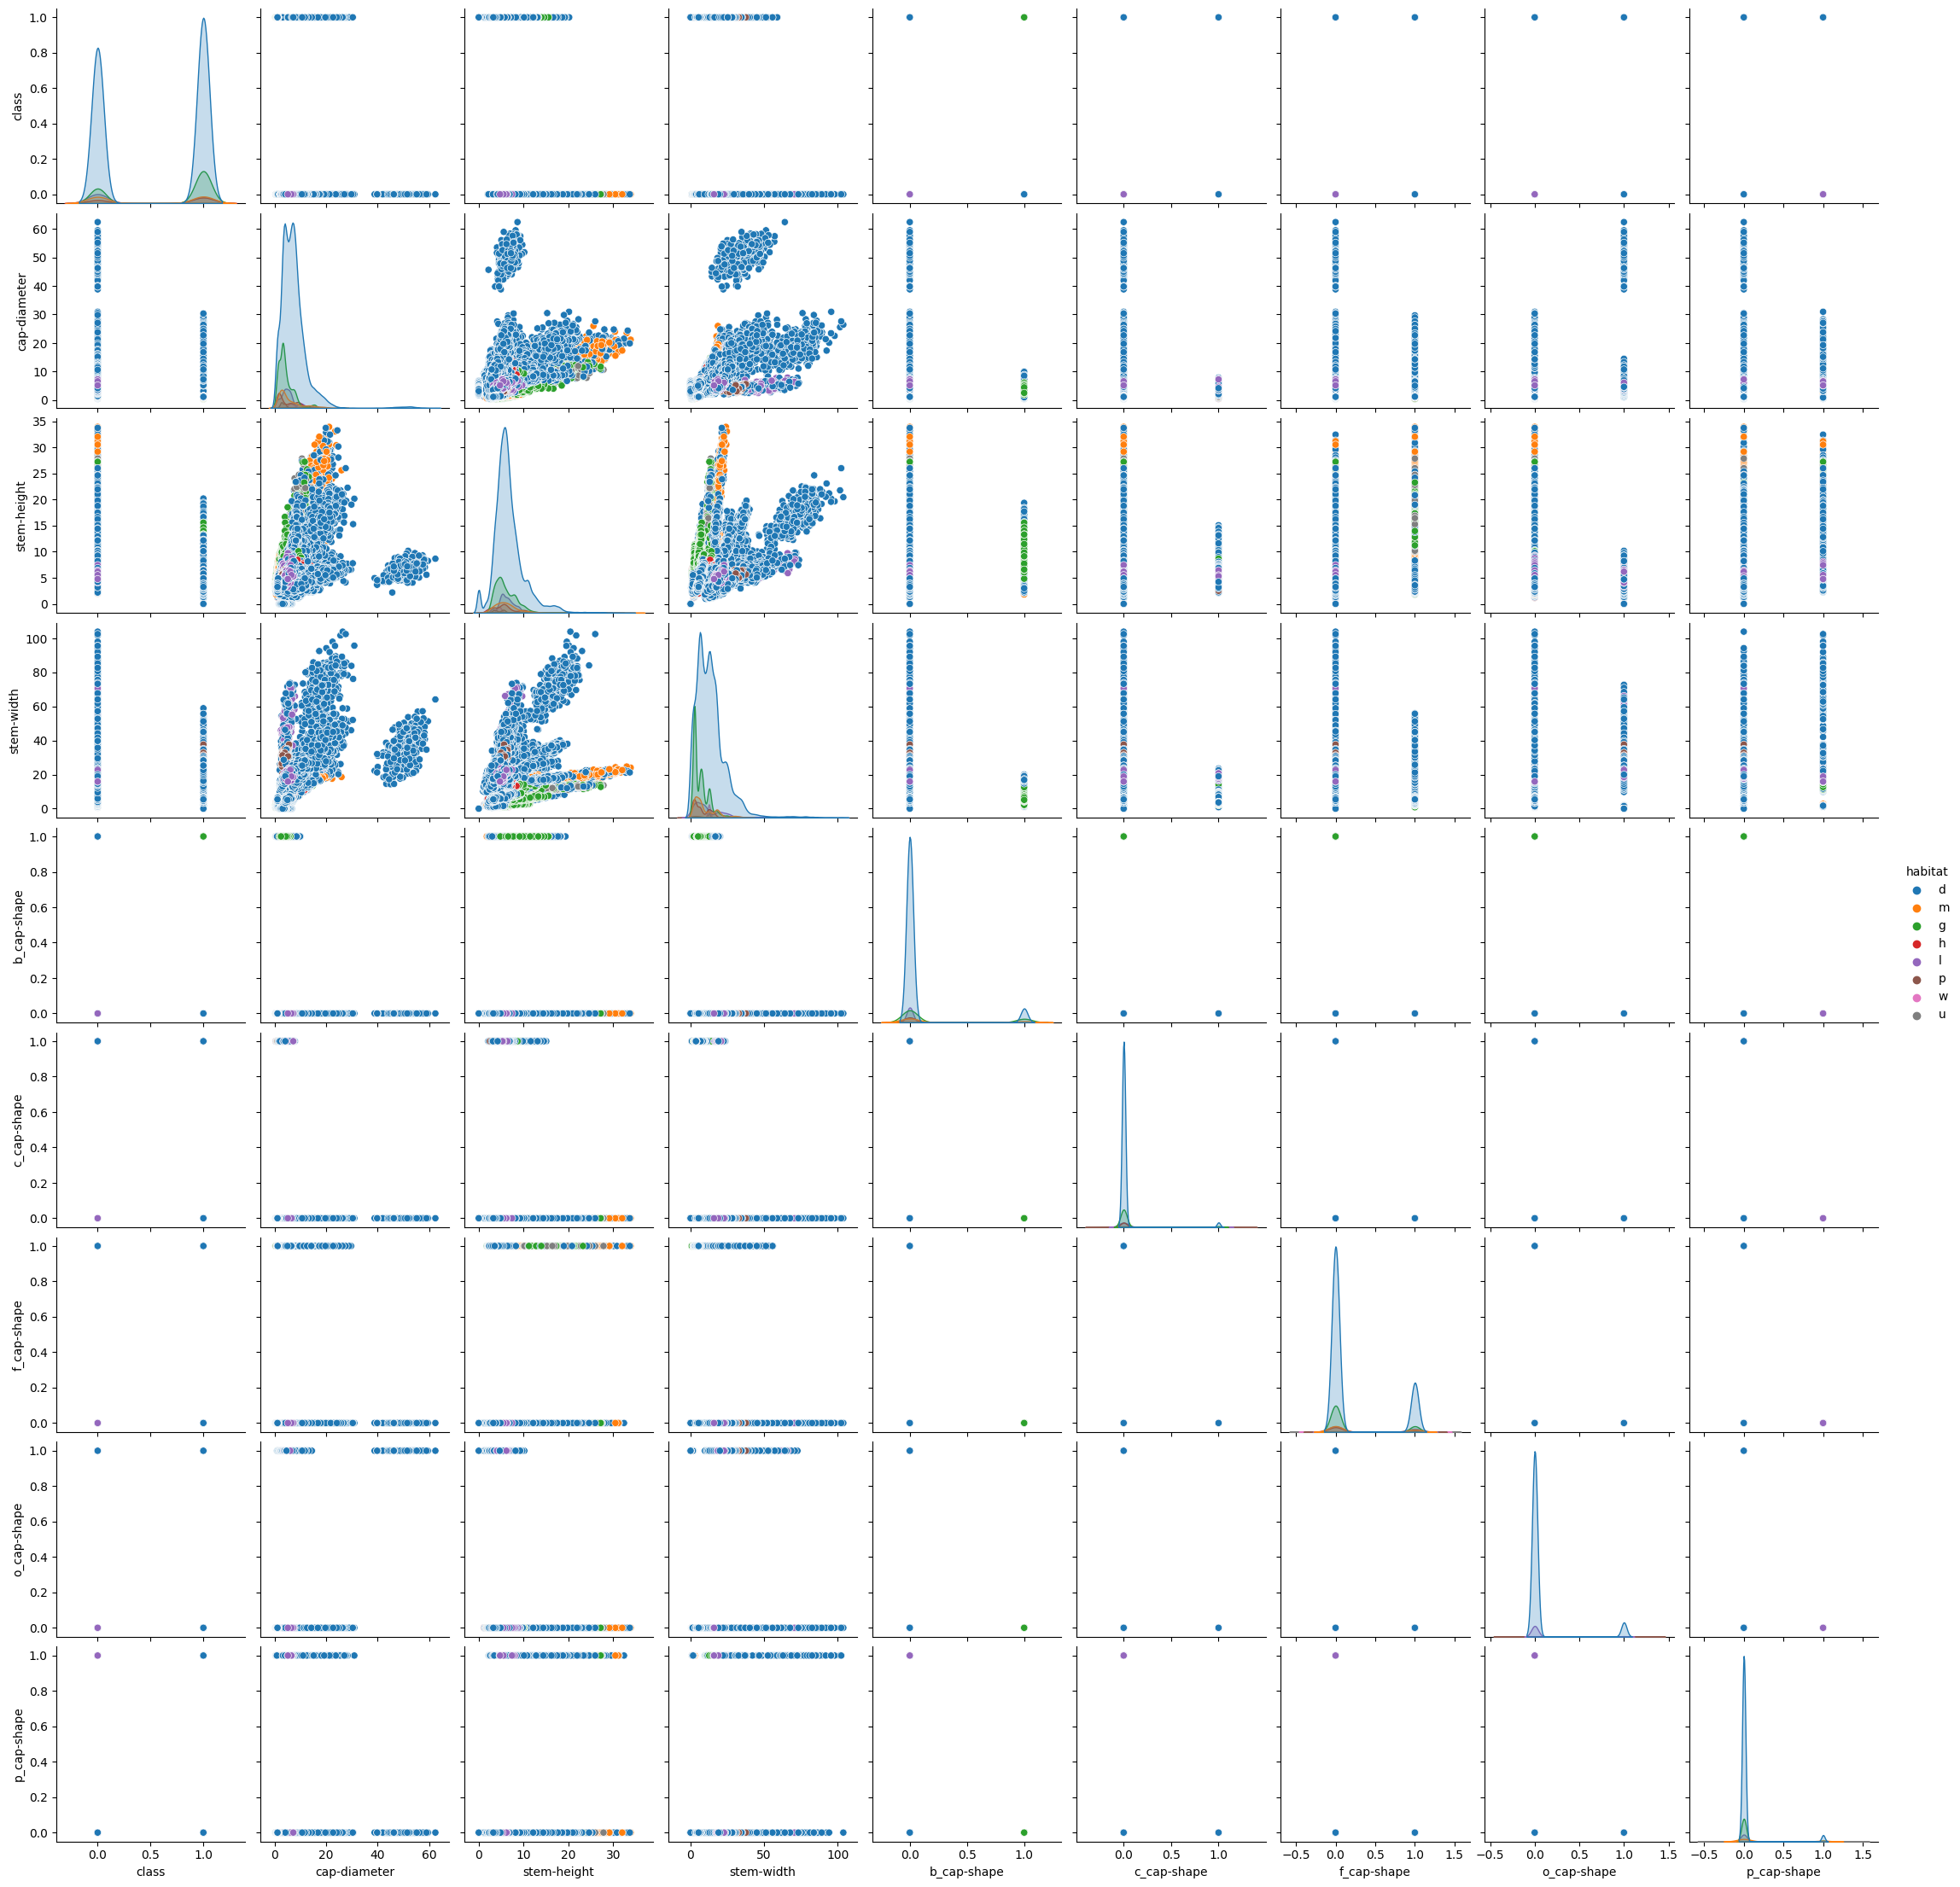

In [27]:
##pairplot by class
sns.pairplot(vis_df, hue='habitat')

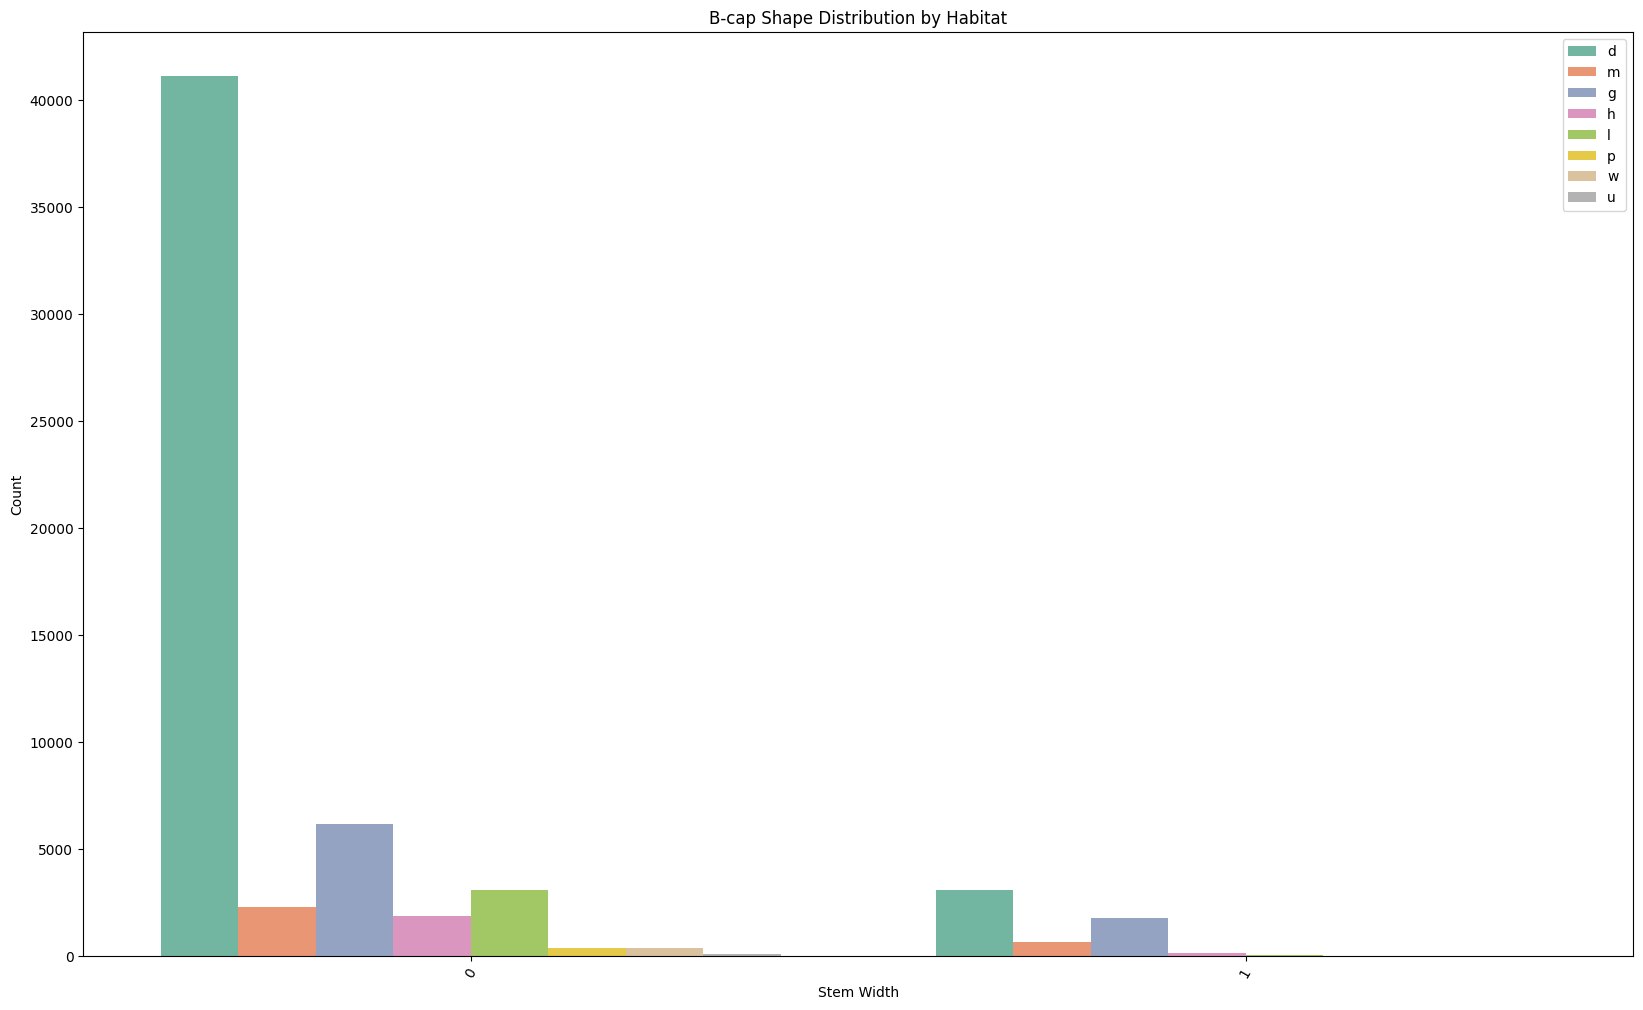

In [28]:
plt.figure(figsize=(20, 12))
sns.countplot(data=vis_df, x=np.array(vis_df['b_cap-shape']), hue=np.array(vis_df['habitat']), palette='Set2')
plt.title('B-cap Shape Distribution by Habitat')
plt.xlabel('Stem Width')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

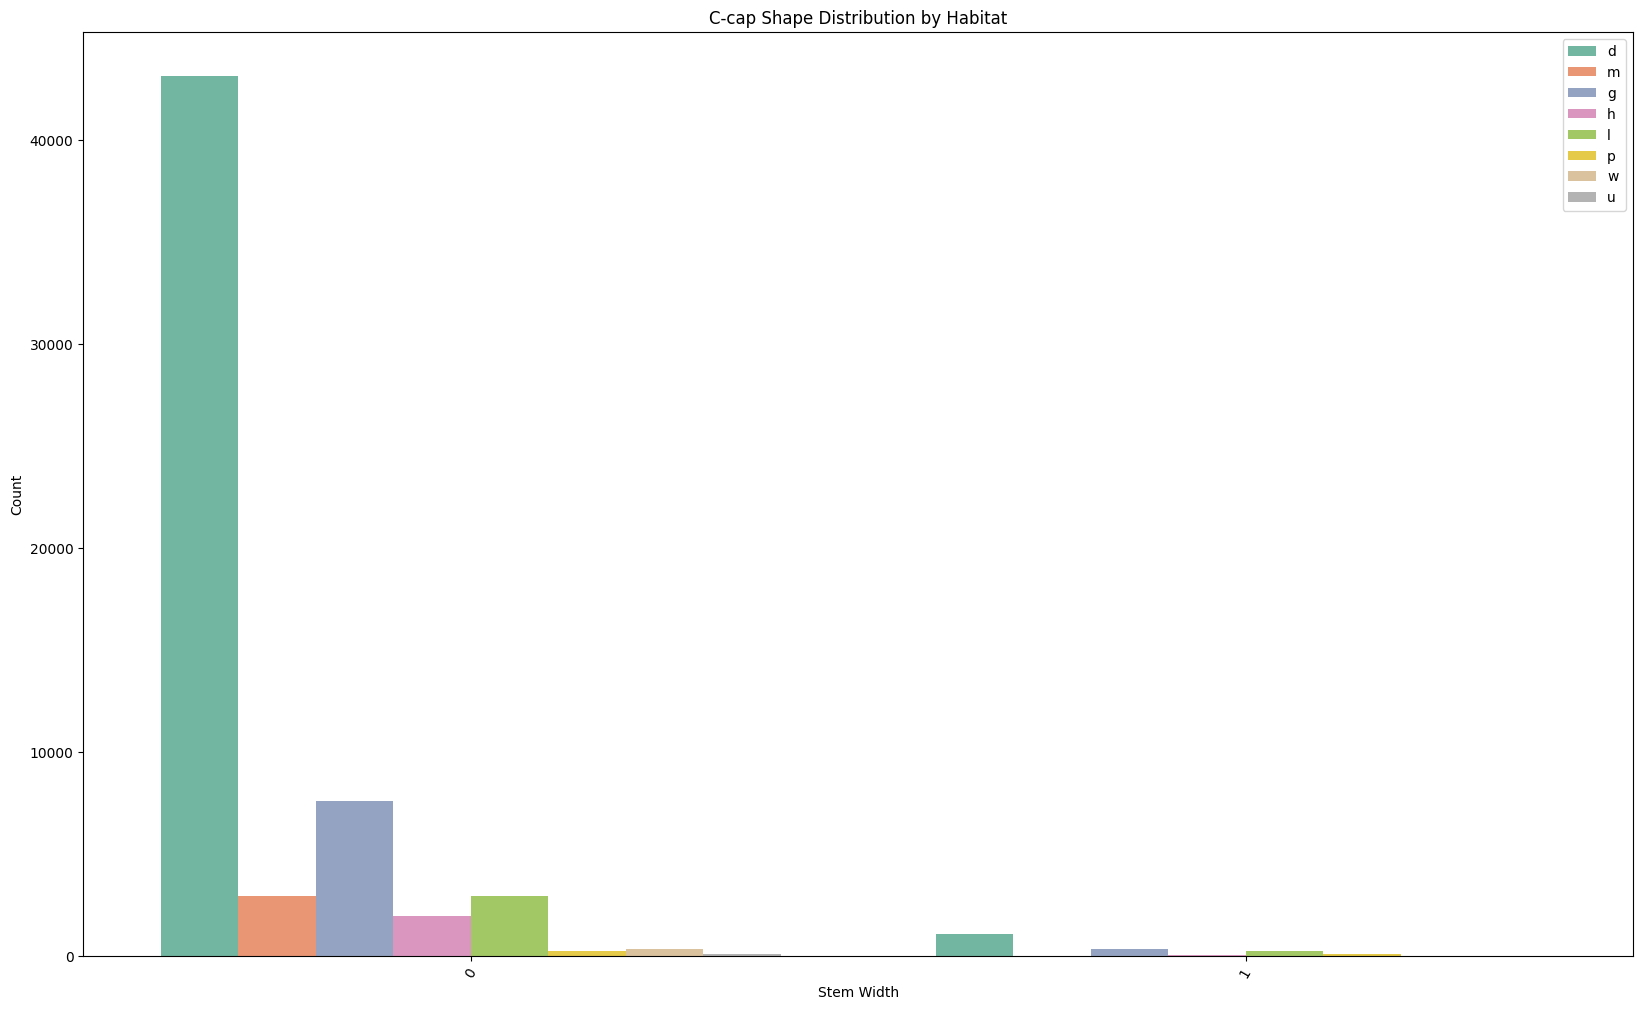

In [29]:
plt.figure(figsize=(20, 12))
sns.countplot(data=vis_df, x=np.array(vis_df['c_cap-shape']), hue=np.array(vis_df['habitat']), palette='Set2')
plt.title('C-cap Shape Distribution by Habitat')
plt.xlabel('Stem Width')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

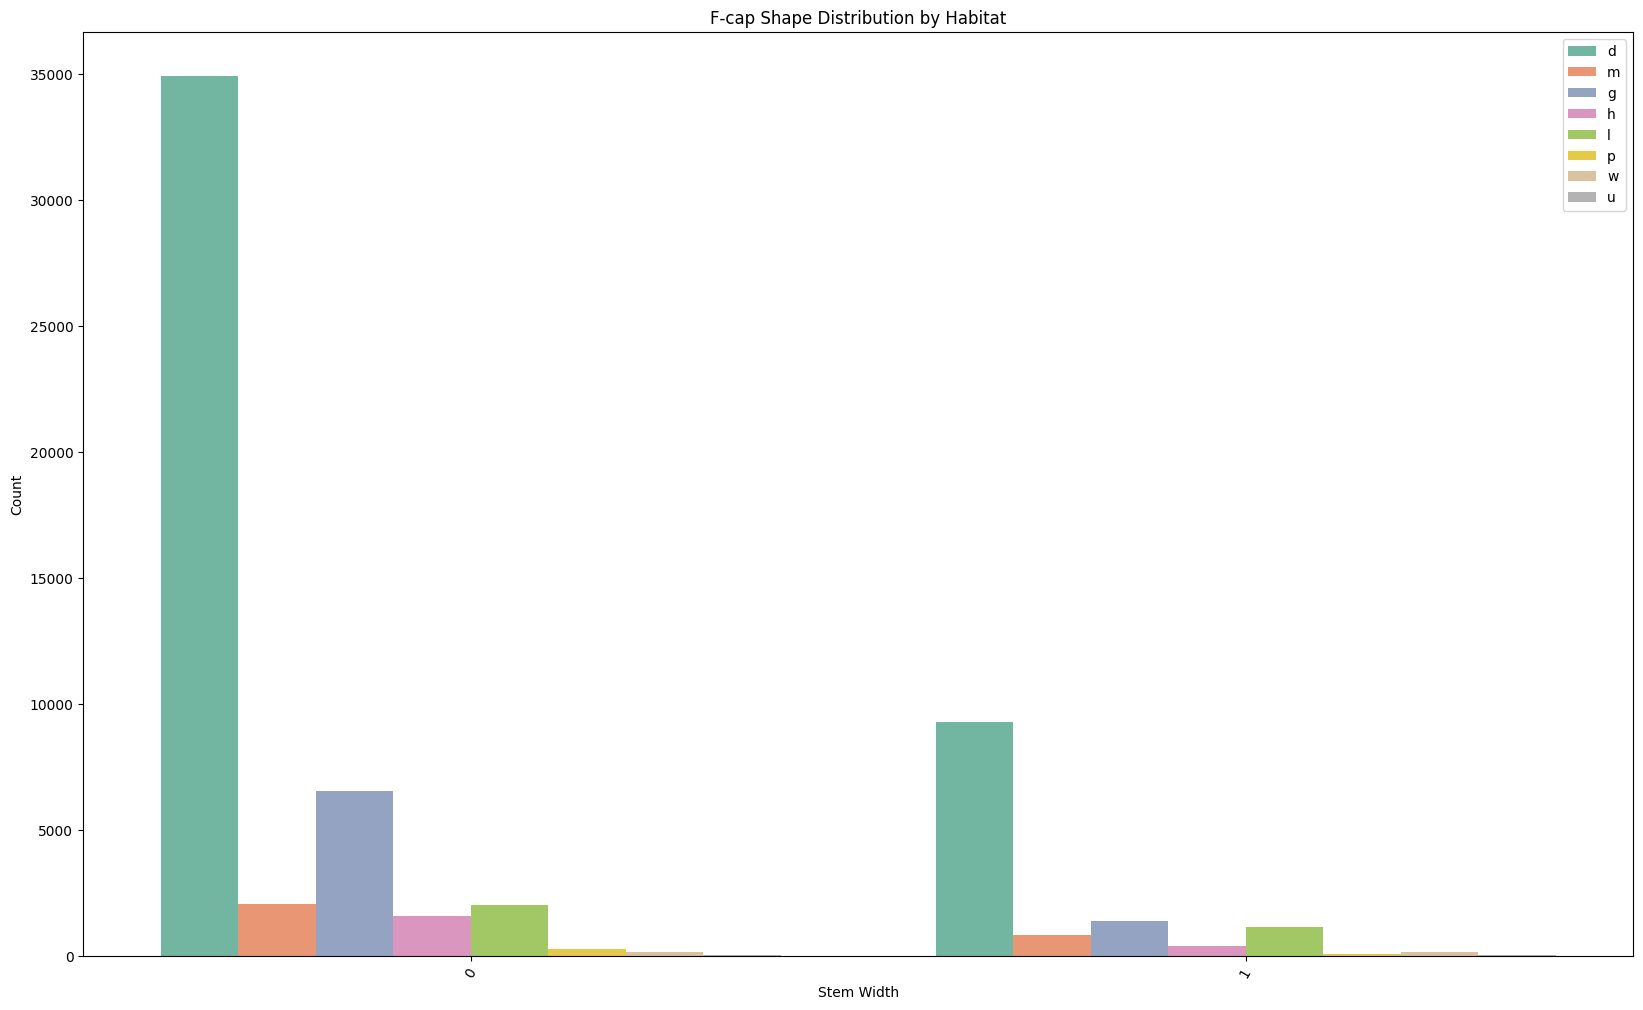

In [30]:
plt.figure(figsize=(20, 12))
sns.countplot(data=vis_df, x=np.array(vis_df['f_cap-shape']), hue=np.array(vis_df['habitat']), palette='Set2')
plt.title('F-cap Shape Distribution by Habitat')
plt.xlabel('Stem Width')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

   class  cap-diameter  stem-height  stem-width  b_cap-shape  c_cap-shape  \
0      1         15.26        16.95       17.09            0            0   
1      1         16.60        17.99       18.19            0            0   
2      1         14.07        17.80       17.74            0            0   
3      1         14.17        15.77       15.98            0            0   
4      1         14.64        16.53       17.20            0            0   

   f_cap-shape  o_cap-shape  p_cap-shape habitat  
0            0            0            0       d  
1            0            0            0       d  
2            0            0            0       d  
3            1            0            0       d  
4            0            0            0       d  


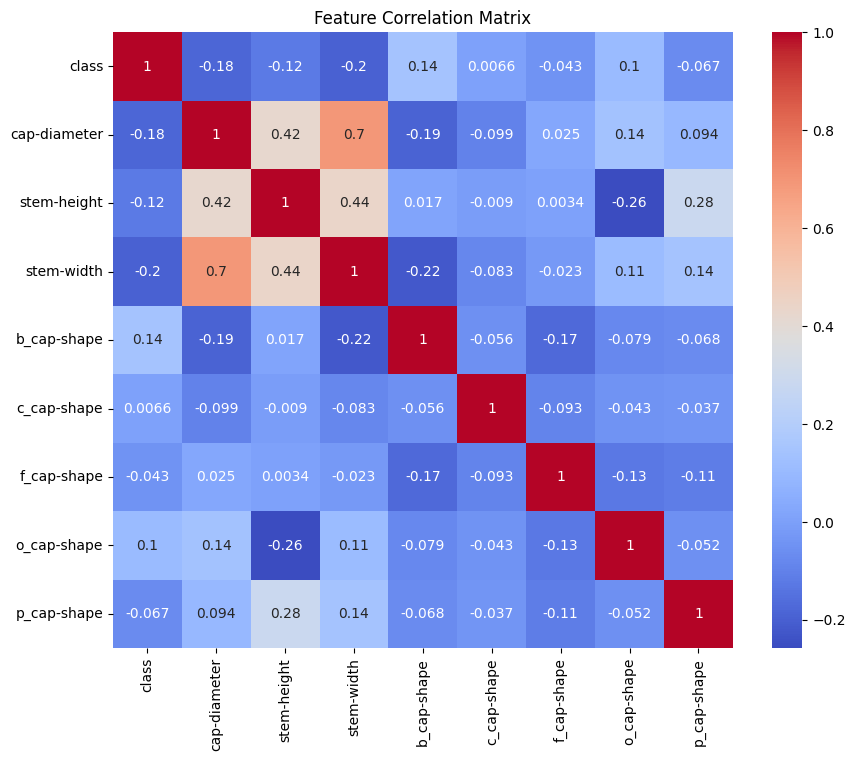

In [31]:
import ast

##creating correlation matrix between relations between all festures to see relation

vis_df_copy = vis_df.copy()

numeric_columns = vis_df_copy.select_dtypes(include=[np.number]).columns
correlation_matrix = vis_df_copy[numeric_columns].corr()

print(vis_df_copy.head())

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Model 1: Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Reason for LabelEncoder
In a standard multi-class logistic regression setting (including the 'multinomial' configuration for LogisticRegression), the target y should be a 1-dimensional array, where each element is a single label representing the class. However, our target has been transformed into a multi-label format, possibly through the use of MultiLabelBinarizer, which would encode each possible class/label as a separate column, resulting in a matrix rather than a single column of labels.

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['habitat'])

In [34]:

X_train, X_temp, y_train, y_temp = train_test_split(X_selected_df, y_encoded, test_size=0.3, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [35]:

model = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))

model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [36]:

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred, zero_division=0))

print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Training Accuracy: 0.7377655094975204
Validation Accuracy: 0.7311282135254625
Test Accuracy: 0.739806779105944
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     30949
           1       0.49      0.11      0.18      5533
           2       0.00      0.00      0.00      1406
           3       0.00      0.00      0.00      2215
           4       0.59      0.22      0.32      2070
           5       0.00      0.00      0.00       249
           6       0.00      0.00      0.00        74
           7       0.69      1.00      0.82       252

    accuracy                           0.74     42748
   macro avg       0.32      0.29      0.27     42748
weighted avg       0.64      0.74      0.66     42748

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      8813
           1       0.46      0.11      0.18    

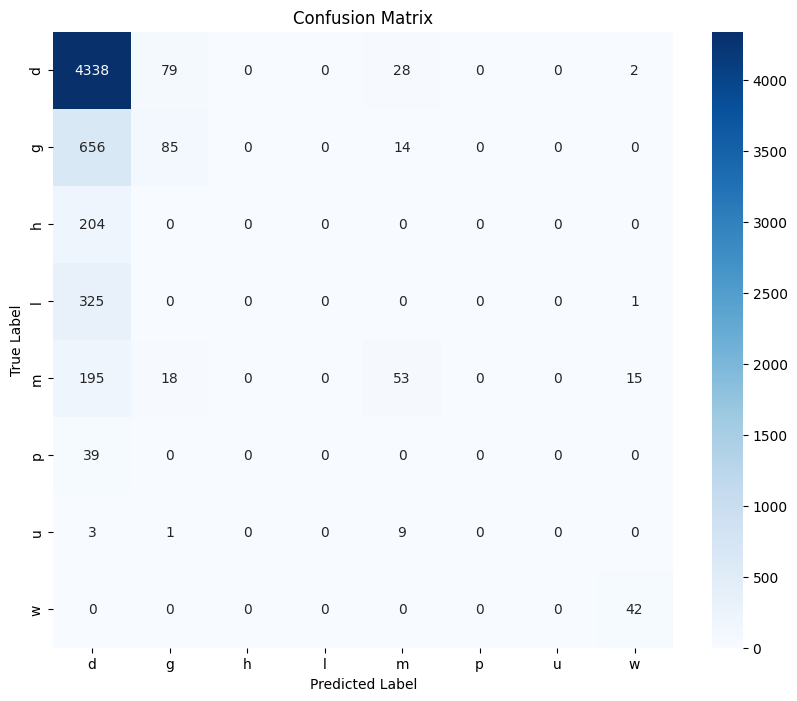

In [37]:

cm = confusion_matrix(y_test, y_test_pred)
class_names = encoder.classes_  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

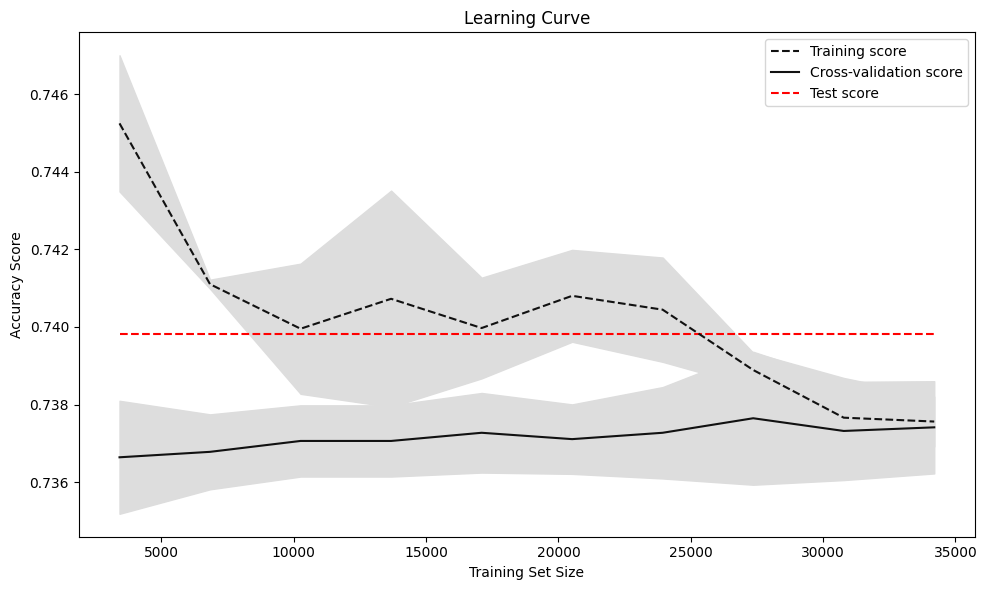

In [38]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,  
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, 
    scoring='accuracy',
    n_jobs=-1 
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)


validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)


test_score = accuracy_score(y_test, y_test_pred)


plt.subplots(1, figsize=(10,6))
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, validation_mean, color="#111111", label="Cross-validation score")


plt.hlines(test_score, train_sizes[0], train_sizes[-1], colors='red', label='Test score', linestyles='dashed')


plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#DDDDDD")


plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


# Model 2: K-Nearest Neighbors

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [40]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['habitat'])

In [41]:

X_train, X_temp, y_train, y_temp = train_test_split(X_selected_df, y_encoded, test_size=0.3, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [42]:
knn = KNeighborsClassifier(n_neighbors=5)

In [43]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [44]:
y_pred = knn.predict(X_test)

In [45]:
# Making predictions on train, validation, and test sets
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

y_train_pred = knn.predict(X_train)
y_val_pred = knn.predict(X_val)
y_test_pred = knn.predict(X_test)

# Evaluating accuracy for each set
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred, zero_division=0))

print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Training Accuracy: 0.7414615888462618
Validation Accuracy: 0.7321925659079744
Test Accuracy: 0.7430817095136728
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     30949
           1       0.46      0.11      0.17      5533
           2       0.00      0.00      0.00      1406
           3       0.51      0.02      0.03      2215
           4       0.71      0.27      0.40      2070
           5       0.00      0.00      0.00       249
           6       0.00      0.00      0.00        74
           7       0.69      1.00      0.82       252

    accuracy                           0.74     42748
   macro avg       0.39      0.30      0.28     42748
weighted avg       0.67      0.74      0.66     42748

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      8813
           1       0.39      0.08      0.13   

In [46]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}  


knn = KNeighborsClassifier()


grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_


print("Best Hyperparameters:", best_params)


best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
best_knn.fit(X_train, y_train)


y_pred = best_knn.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with Best Model:", accuracy)


print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred, zero_division=0))

Best Hyperparameters: {'n_neighbors': 9}
Test Accuracy with Best Model: 0.7470116260029475
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.75      0.99      0.86      4447
           1       0.49      0.04      0.08       755
           2       0.00      0.00      0.00       204
           3       0.00      0.00      0.00       326
           4       0.70      0.25      0.36       281
           5       0.43      0.51      0.47        39
           6       0.11      0.08      0.09        13
           7       0.70      1.00      0.82        42

    accuracy                           0.75      6107
   macro avg       0.40      0.36      0.33      6107
weighted avg       0.65      0.75      0.66      6107



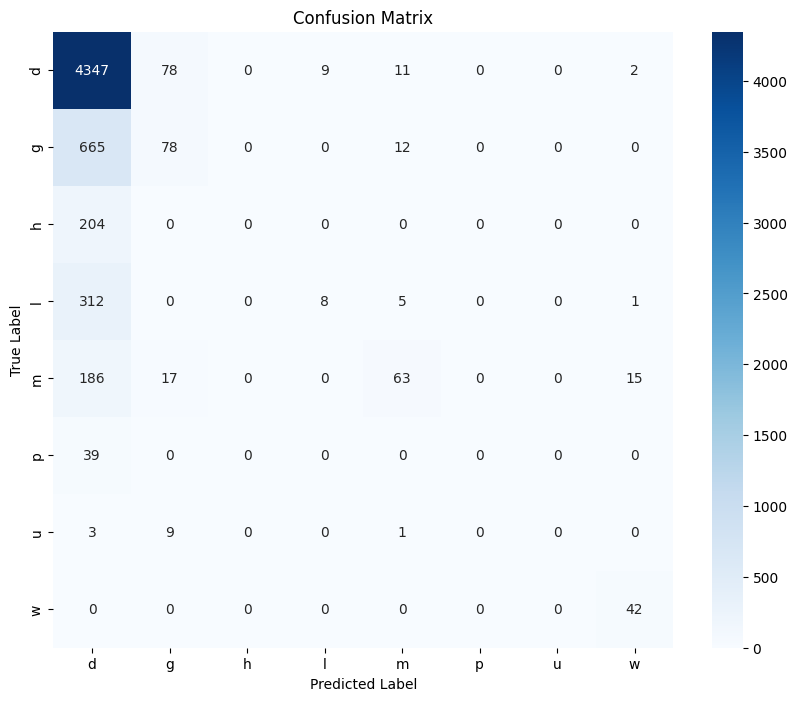

In [47]:

cm = confusion_matrix(y_test, y_test_pred)
class_names = encoder.classes_ 

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

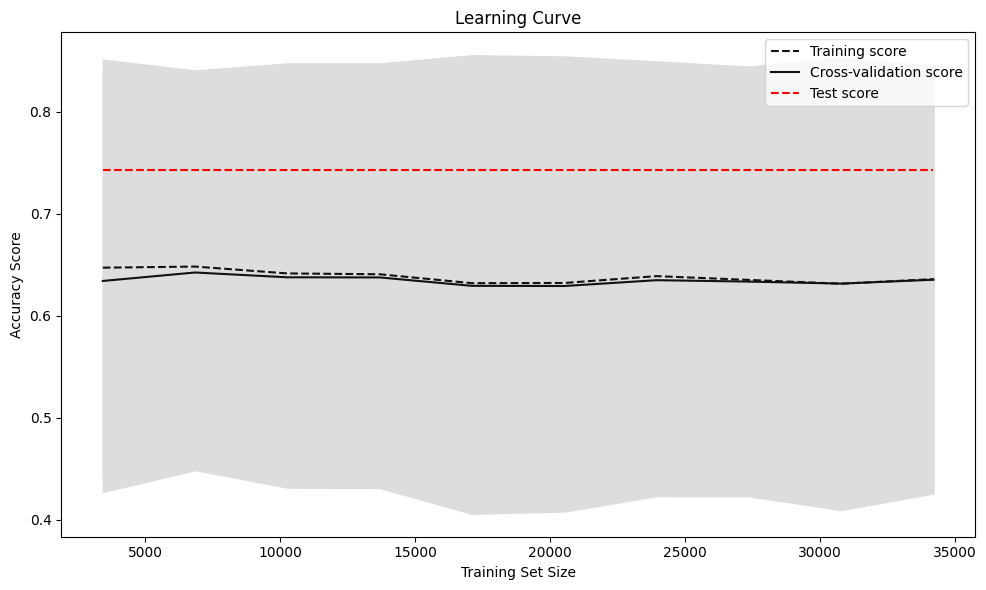

In [48]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, validation_scores = learning_curve(
    estimator=knn,
    X=X_train, 
    y=y_train,  
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,  
    scoring='accuracy',
    n_jobs=-1 
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)


validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

test_score = accuracy_score(y_test, y_test_pred)


plt.subplots(1, figsize=(10,6))
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, validation_mean, color="#111111", label="Cross-validation score")


plt.hlines(test_score, train_sizes[0], train_sizes[-1], colors='red', label='Test score', linestyles='dashed')


plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [49]:
import matplotlib.pyplot as plt
import pandas as pd

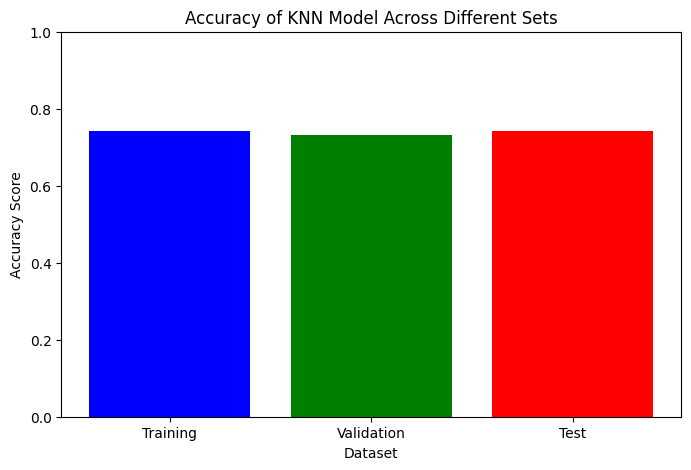

In [50]:
import matplotlib.pyplot as plt


accuracies = [train_accuracy, val_accuracy, test_accuracy]
labels = ['Training', 'Validation', 'Test']

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy Score')
plt.title('Accuracy of KNN Model Across Different Sets')
plt.ylim(0, 1)
plt.show()


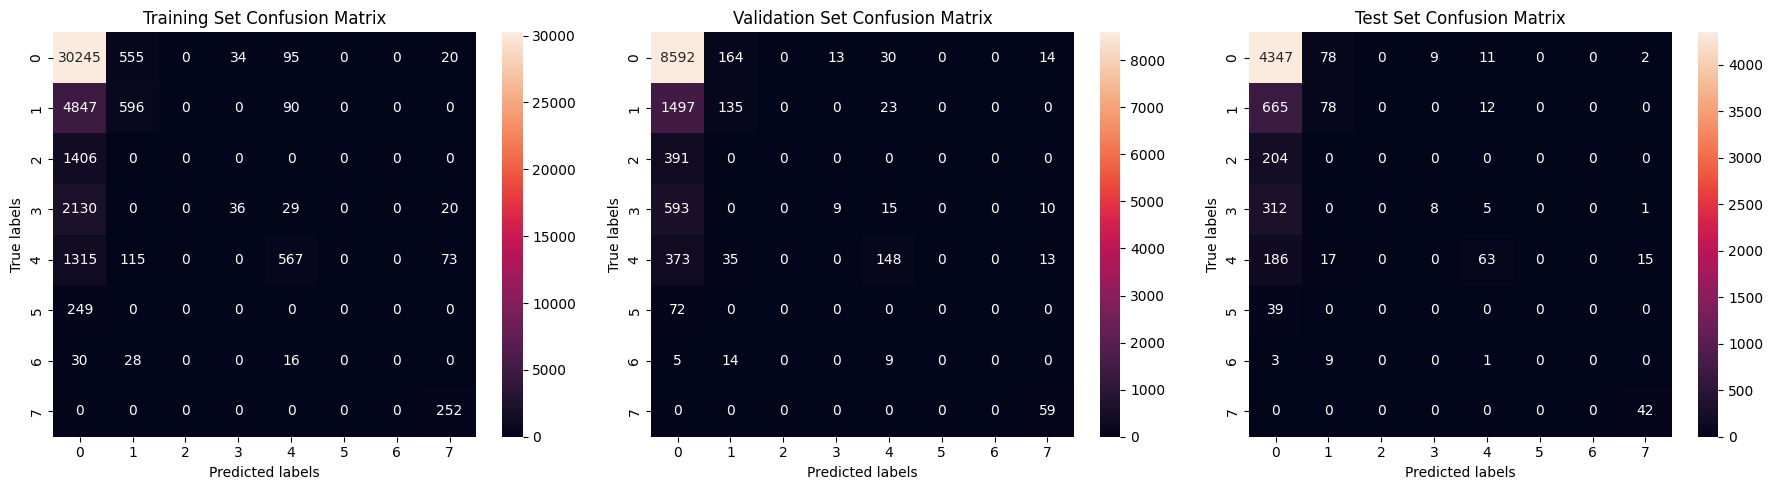

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_train, annot=True, ax=ax[0], fmt='g')
ax[0].set_title('Training Set Confusion Matrix')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')

sns.heatmap(cm_val, annot=True, ax=ax[1], fmt='g')
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')

sns.heatmap(cm_test, annot=True, ax=ax[2], fmt='g')
ax[2].set_title('Test Set Confusion Matrix')
ax[2].set_xlabel('Predicted labels')
ax[2].set_ylabel('True labels')

plt.tight_layout()
plt.show()
